In this experiment, we use t-SNE to embed events, represented by: event date, title, and summary.

The key point is that we don't include article counts, but the embeddings are still partially clustered by article counts, even though they never saw them.

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
from openTSNE import TSNE
import os
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_pickle("../../data/text/data_with_embeds.pkl")

In [4]:
df['article_count'].mean()

13.216880259299911

In [3]:
df.head()

lang                                              title  \
id                                                             
e_11  eng                  Bombing survivor and nurse to wed   
e_10  eng               Trade Idea: GBP/USD - Sell at 1.6450   
e_13  eng  Too cool for Yule? Have a hipster Christmas in...   
e_12  eng  Opening Bell: Cues that will help you trade be...   
e_15  eng                       On Colorado shooter's arm...   

                                                summary article_count  \
id                                                                      
e_11  A man seriously wounded in the Boston bombing ...             7   
e_10  Although the British pound rallied to 1.6485 y...           221   
e_13  Unlike you, hipsters don't want any old Christ...             9   
e_12  The Sensex plunged 210.03 points to 20,715.58 ...             1   
e_15  (CNN) -- Colorado shooter Karl Pierson had wri...             8   

     event_date                                        title_embed  \
id                                                                   
e_11      16057  [0.47470707, -0.08501352, 0.26899937, -0.36353...   
e_10      16058  [0.17094071, -0.18888026, 0.28712985, -0.36104...   
e_13      16059  [0.2537402, -0.032281302, 0.37904784, -0.31818...   
e_12      16054  [0.23880291, 0.03649398, 0.32137018, -0.170995...   
e_15      16057  [0.3985864, -0.06734807, 0.40732777, -0.461210...   

                                          summary_embed  
id                                                       
e_11  [0.3377615, -0.26158097, 0.3140225, -0.2120716...  
e_10  [0.1786896, -0.11662727, 0.19326286, -0.20948,...  
e_13  [0.026874868, -0.09318099, 0.03552014, -0.0260...  
e_12  [0.46094257, -0.36103615, 0.31917268, -0.60180...  
e_15  [0.5053371, -0.062929116, 0.27972195, -0.43177...

In [4]:
print(f"{np.sum(df['article_count'] >= 40) / df.shape[0] * 100:.2f}% of rows have >= 40 articles")

4.65% of rows have >= 40 articles


In [5]:
event_dates = df['event_date'].values.reshape(-1, 1)

x = np.concatenate([event_dates, df['title_embed'].tolist(), df['summary_embed'].tolist()], axis=1)
y = df['article_count']

In [9]:
if os.path.exists("../../data/text/tsne_train_test_noCheat.pkldsd"):
    print("Loading train test split from pickle")
    x_train, x_test, y_train, y_test = pickle.load(open("../../data/text/tsne_train_test_noCheat.pkl", "rb"))
else:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    pickle.dump((x_train, x_test, y_train, y_test), open("../../data/text/tsne_train_test_noCheat.pkl", "wb"))

In [10]:
print("%d training samples" % x_train.shape[0])
print("%d test samples" % x_test.shape[0])

155248 training samples
38813 test samples


In [11]:
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

In [13]:
if os.path.exists("../../data/text/llm_tsne_train_noCheat.pkl"):
    print("Loading tSNE from pickle")
    embedding_train = pickle.load(open("../../data/text/llm_tsne_train_noCheat.pkl", "rb"))
    embedding_test = pickle.load(open("../../data/text/llm_tsne_test_noCheat.pkl", "rb"))
else:
    print("Fitting train TSNE")
    embedding_train = tsne.fit(x_train)
    embedding_test = embedding_train.transform(x_test)
    print("Saving to pickle")
    pickle.dump(embedding_train, open("../../data/text/llm_tsne_train_noCheat.pkl", "wb"))
    pickle.dump(embedding_test, open("../../data/text/llm_tsne_test_noCheat.pkl", "wb"))

print("Done")

Loading tSNE from pickle
Done


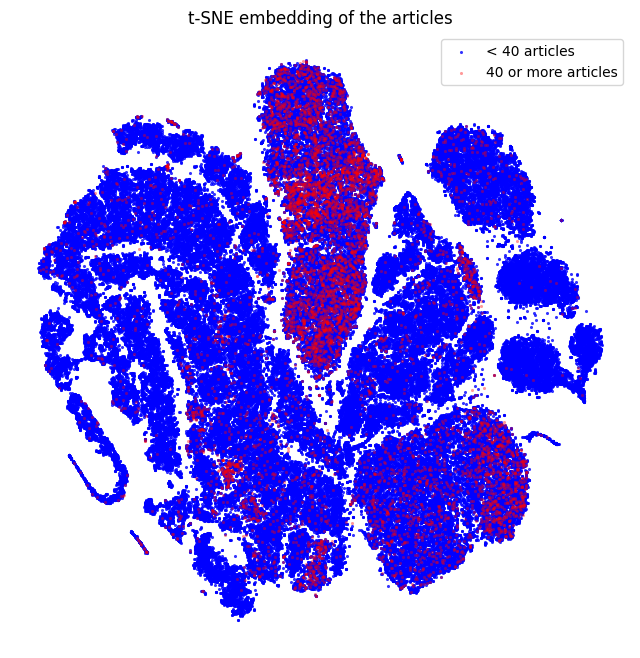

In [14]:
plt.figure(figsize=(8, 8))

mask = y_train >= 40

plt.scatter(embedding_train[~mask, 0], embedding_train[~mask, 1], 
            c='blue', alpha=0.8, s=5, linewidths=0, label="< 40 articles")
plt.scatter(embedding_train[mask, 0], embedding_train[mask, 1], 
            c='red', alpha=0.4, s=5, linewidths=0, label="40 or more articles")

plt.axis('off')
plt.title("t-SNE embedding of the articles")
plt.legend()


plt.show()

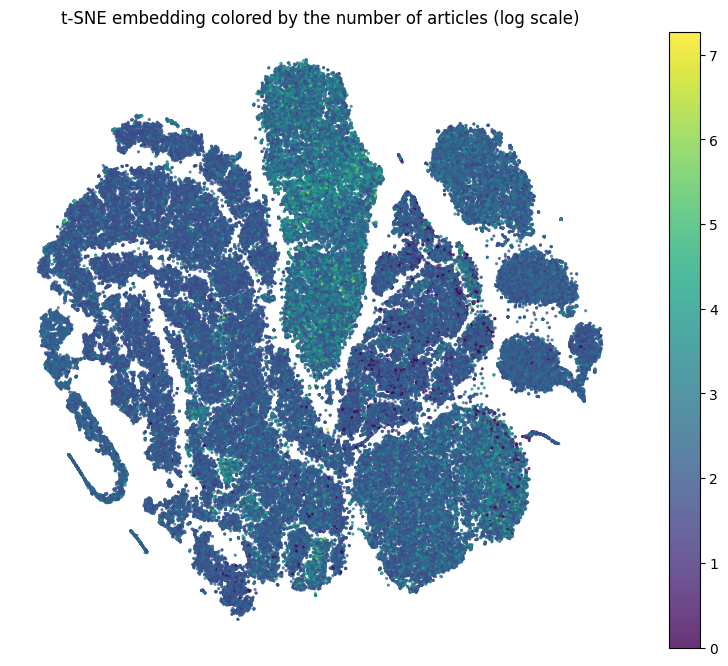

In [15]:
train_idx = y_train.index
y_counts = df.loc[train_idx]['article_count']
counts_log = y_counts.apply(lambda x: np.log(x))

plt.figure(figsize=(10, 8))

plt.scatter(embedding_train[:, 0], embedding_train[:, 1], 
            c=counts_log, alpha=0.8, s=5, linewidths=0, cmap='viridis')

plt.axis('off')
plt.title("t-SNE embedding colored by the number of articles (log scale)")
plt.colorbar()

plt.show()

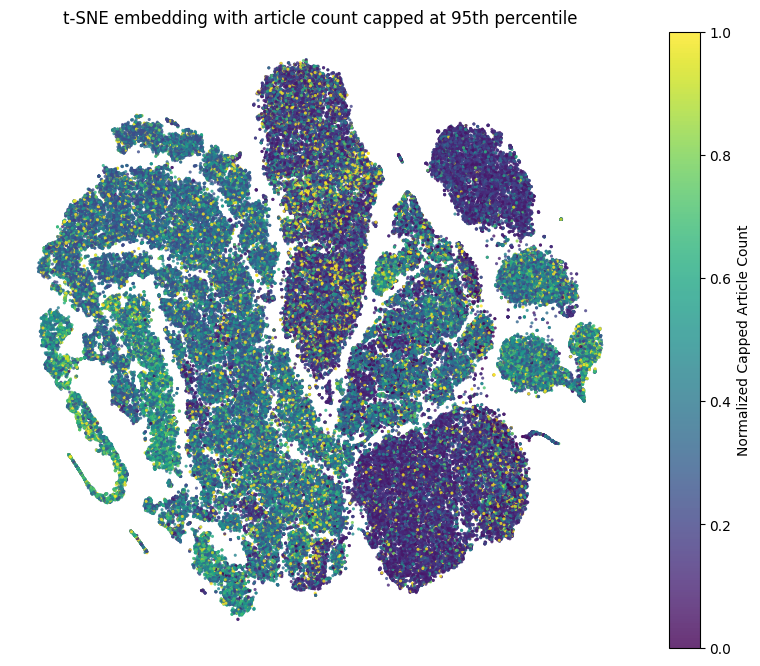

In [16]:
# Define a function to cap values at a certain percentile
def cap_at_percentile(s, percentile=95):
    cap_value = np.percentile(s, percentile)
    return np.where(s > cap_value, cap_value, s)

# Apply the function within each language group
capped_counts = df.groupby('lang')['article_count'].transform(
    lambda x: cap_at_percentile(x, 95)
)

# Normalizing the capped counts within each language
normalized_capped_counts = capped_counts.groupby(df['lang']).transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Getting the normalized capped counts for the training set
normalized_capped_counts_train = normalized_capped_counts.loc[train_idx]

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding_train[:, 0], embedding_train[:, 1],
                      c=normalized_capped_counts_train, alpha=0.8, s=5,
                      linewidths=0, cmap='viridis')

plt.axis('off')
plt.title("t-SNE embedding with article count capped at 95th percentile")
plt.colorbar(scatter, label='Normalized Capped Article Count')

plt.show()

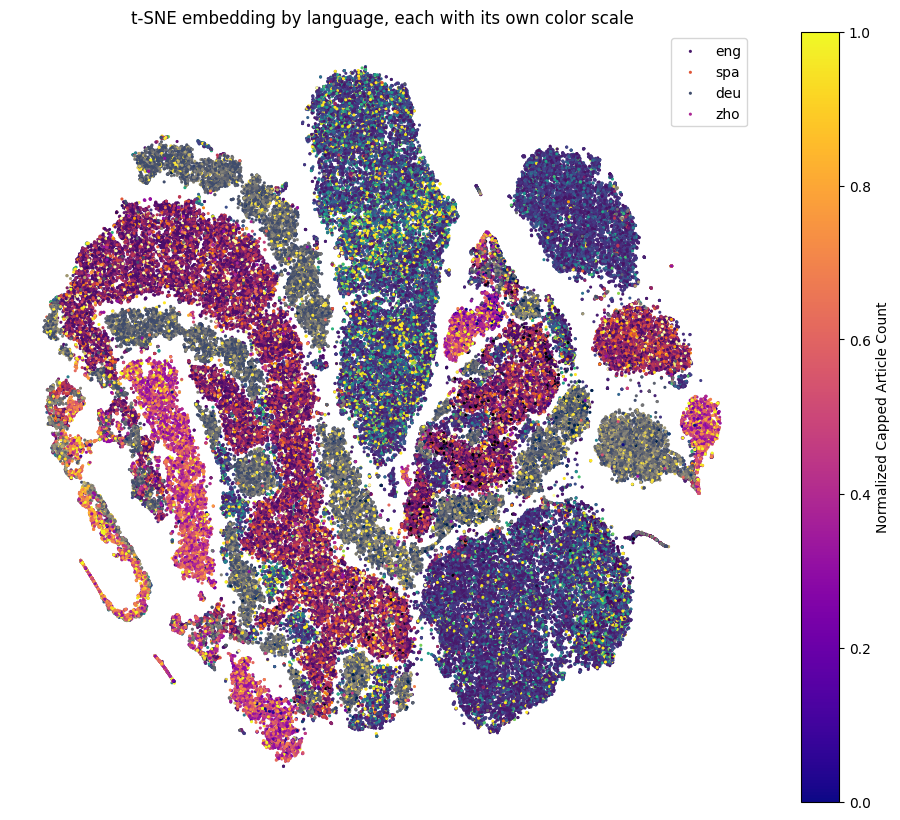

In [17]:
# Define a function to cap values at a certain percentile
def cap_at_percentile(s, percentile=95):
    cap_value = np.percentile(s, percentile)
    return np.where(s > cap_value, cap_value, s)

# Apply the function within each language group
capped_counts = df.groupby('lang')['article_count'].transform(
    lambda x: cap_at_percentile(x, 95)
)

# Normalizing the capped counts within each language
normalized_capped_counts = capped_counts.groupby(df['lang']).transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Getting the normalized capped counts for the training set
normalized_capped_counts_train = normalized_capped_counts.loc[train_idx]

# Define a mapping from language to colormap
lang_colormap = {
    'eng': 'viridis',
    'spa': 'inferno',
    'deu': 'cividis',
    'zho': 'plasma'
}

plt.figure(figsize=(12, 10))

# Plot each language with its own colormap
for lang, cmap in lang_colormap.items():
    # Filter the points for the current language
    lang_indices = df.loc[train_idx, 'lang'] == lang
    lang_embedding = embedding_train[lang_indices]
    lang_counts = normalized_capped_counts_train[lang_indices]

    # Plot
    plt.scatter(lang_embedding[:, 0], lang_embedding[:, 1], 
                c=lang_counts, alpha=1, s=5, linewidths=0, cmap=cmap, label=lang)

plt.axis('off')
plt.title("t-SNE embedding by language, each with its own color scale")
plt.colorbar(label='Normalized Capped Article Count')
plt.legend()
plt.show()


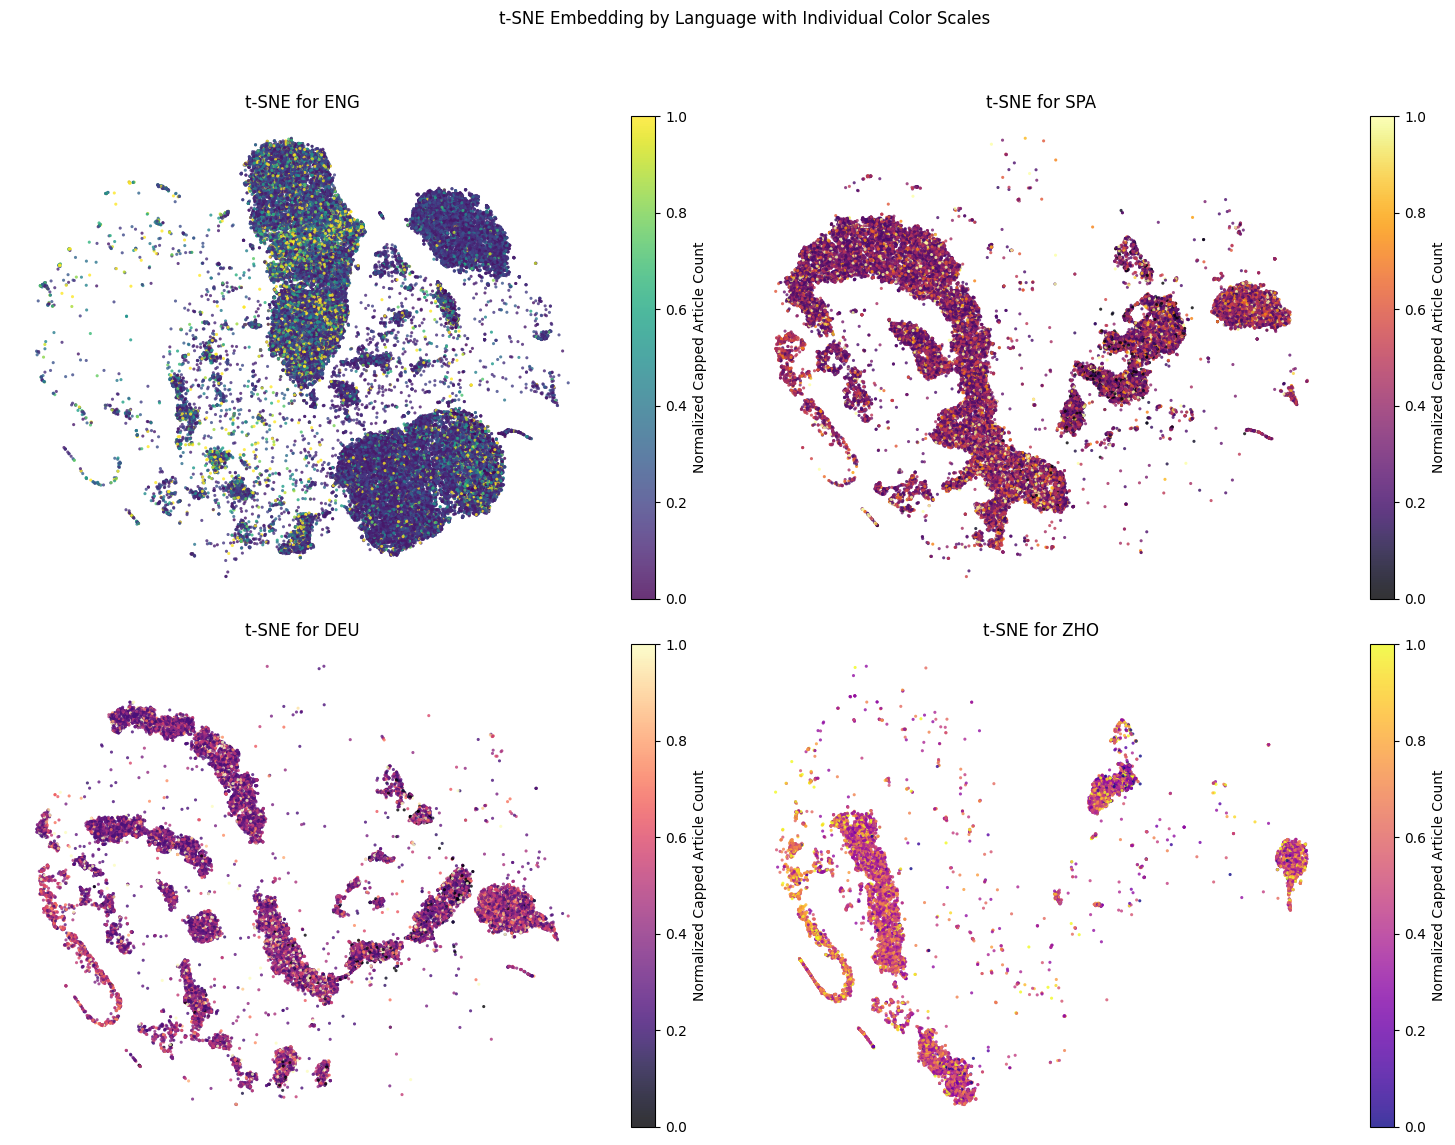

In [18]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Assuming embedding_train, df, and normalized_capped_counts_train are already defined

# Define a mapping from language to colormap
lang_colormap = {
    'eng': 'viridis',
    'spa': 'inferno',
    'deu': 'magma',
    'zho': 'plasma'
}

# Create a grid for subplots
plt.figure(figsize=(15, 12))
gs = gridspec.GridSpec(2, 2)

# Plot each language in a separate subplot
for i, (lang, cmap) in enumerate(lang_colormap.items()):
    ax = plt.subplot(gs[i])
    
    # Filter the points for the current language
    lang_indices = df.loc[train_idx, 'lang'] == lang
    lang_embedding = embedding_train[lang_indices]
    lang_counts = normalized_capped_counts_train[lang_indices]

    # Scatter plot
    scatter = ax.scatter(lang_embedding[:, 0], lang_embedding[:, 1],
                         c=lang_counts, alpha=0.8, s=5, linewidths=0, cmap=cmap)
    
    ax.set_title(f"t-SNE for {lang.upper()}")
    ax.axis('off')

    # Adding a colorbar for each subplot
    plt.colorbar(scatter, ax=ax, label='Normalized Capped Article Count')

plt.suptitle("t-SNE Embedding by Language with Individual Color Scales")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the title
plt.show()


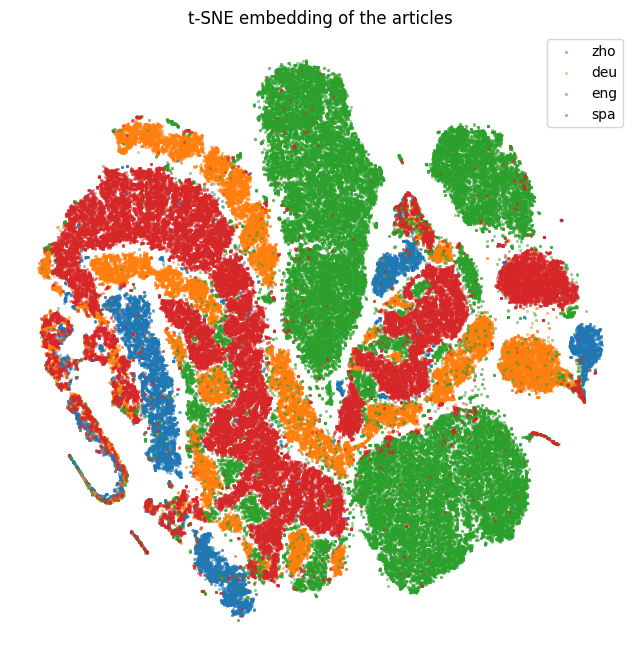

In [19]:
plt.figure(figsize=(8, 8))

df_train = df.loc[y_train.index]
for lang in df_train['lang'].unique():
    mask = df_train['lang'] == lang
    plt.scatter(embedding_train[mask, 0], embedding_train[mask, 1], 
                alpha=0.5, s=5, linewidths=0, label=lang)

plt.axis('off')
plt.title("t-SNE embedding of the articles")
plt.legend()

plt.show()

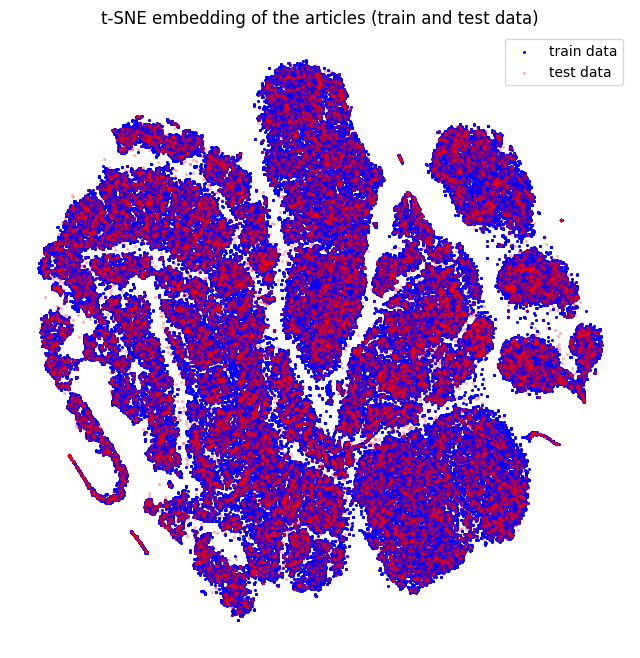

In [20]:
# plot the test embeddings on top of the train embeddings

plt.figure(figsize=(8, 8))

# Training data (blue)

plt.scatter(embedding_train[:, 0], embedding_train[:, 1], 
            c='blue', alpha=1, s=5, linewidths=0, label="train data")

# Test data (red)

plt.scatter(embedding_test[:, 0], embedding_test[:, 1], 
            c='red', alpha=0.3, s=5, linewidths=0, label="test data")

plt.axis('off')
plt.title("t-SNE embedding of the articles (train and test data)")
plt.legend()

plt.show()


In [21]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)

In [22]:
# Create the KNN regressor with the number of neighbors you want to consider
knn = KNeighborsRegressor(n_neighbors=5)

# Train the regressor on the training data
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [23]:
# Make predictions on the test data
y_pred = knn.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 490.1521727256332


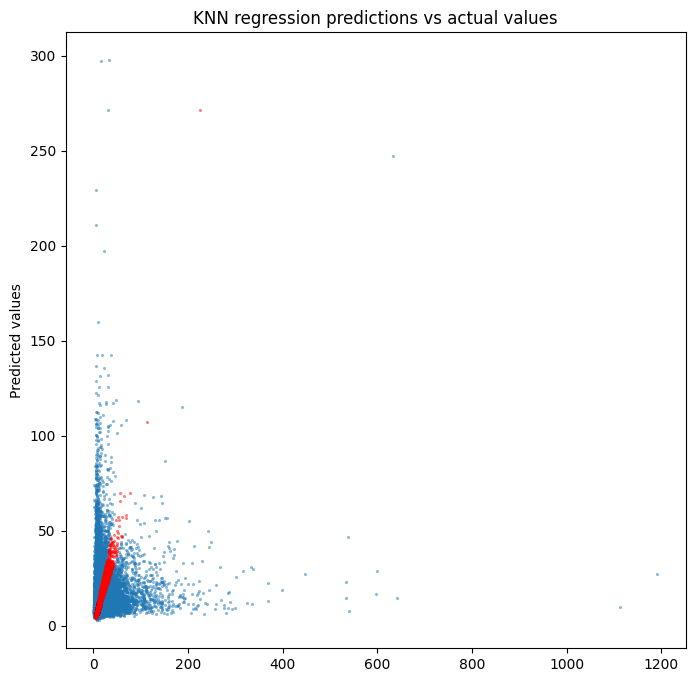

In [24]:
# Plot the predictions vs the actual values
plt.figure(figsize=(8, 8))

# plt.scatter(y_test, y_pred, alpha=0.25, s=10, linewidths=0)
# plt.xlabel("Actual values")

# color the points that are within 25% of the actual value in red
mask = np.abs(y_test - y_pred) / y_test <= 0.25
plt.scatter(y_test[~mask], y_pred[~mask], alpha=0.5, s=5, linewidths=0)
plt.scatter(y_test[mask], y_pred[mask], alpha=0.5, s=5, linewidths=0, c='red')


plt.ylabel("Predicted values")
plt.title("KNN regression predictions vs actual values")

plt.show()

In [25]:
y_pred_sorted = np.sort(y_pred)[::-1]
y_test_sorted = np.sort(y_test)[::-1]
def get_top_x_L1(percent=0.1):
    top_percent = int(y_test.shape[0] * percent)
    
    y_test_p = y_test_sorted[:top_percent]
    y_pred_p = y_pred_sorted[:top_percent]
    
    mean_l1_error = np.mean(np.abs(y_test_p - y_pred_p))
    mean_relative_error = np.mean(np.abs(y_test_p - y_pred_p) / y_test_p)
    print(f"Mean L1 error for the top {round(x * 100)}% of rows with the most articles: {round(mean_l1_error, 2)} ({round(mean_relative_error * 100, 2)}%)")

In [26]:
for x in [0.1, 0.2, 0.3, 0.4, 0.5, 1]:
    get_top_x_L1(x)

Mean L1 error for the top 10% of rows with the most articles: 16.09 (20.71%)
Mean L1 error for the top 20% of rows with the most articles: 9.03 (16.49%)
Mean L1 error for the top 30% of rows with the most articles: 6.87 (18.0%)
Mean L1 error for the top 40% of rows with the most articles: 5.61 (18.04%)
Mean L1 error for the top 50% of rows with the most articles: 4.71 (16.92%)
Mean L1 error for the top 100% of rows with the most articles: 3.16 (26.14%)


In [27]:
# get l1, mse and mape
def get_metrics(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mape = np.mean(np.abs(y_test - y_pred) / y_test)
    l1 = np.mean(np.abs(y_test - y_pred))
    return mse, mape, l1


In [28]:
# get metrics for the whole dataset
mse, mape, l1 = get_metrics(y_test, y_pred)
print(f"MSE: {mse}")
print(f"MAPE: {mape}")
print(f"L1: {l1}")

MSE: 490.1521727256332
MAPE: 0.8514401500749506
L1: 8.864880323603032
